## Implenting ASA's Player Roles Clustering

In this post, we're gonna go work out the stuff from this excellent [blog](https://www.americansocceranalysis.com/home/2020/8/3/defining-roles-how-every-player-contributes-to-goals) by the guys over at American Soccer Analysis

The final clustering ended up using 19 statistics: 
*    shots, 
*    non-penalty expected goals (npxG), 
*    key passes (KP), 
*    expected assists (xA), 
*    xGChain, 
*    xBuildup (xB), 
*    Pass%, 
*    crosses, 
*    successful dribbles, 
*    vertical passing distance, 
*    miscontrolled passes, 
*    times targeted by a pass, 
*    % of player passes that were short
*    % of player passes that were long.
*    progressive passing distance, 
*    crosses into the penalty area, 
*    expected pass percentage (xPass%), 


*    % of possession chains in which a player participated with a shot, 
*    % of chains in which a player participated with a KP, 


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

In [2]:
scaler = MinMaxScaler()

df = pd.read_csv("data.csv")

df = df[["Player", "Pos", "90s", "Standard_Sh", "Expected_npxG", "KP", "xA", "xGChain", "xGBuildup", 
         "Total_Cmp%", "Pass Types_Crs", "Dribbles_Succ", "Miscon", "Receiving_Targ",
         "Total_PrgDist", "CrsPA", "Prog", "Total_Cmp", "Short_Cmp", "Medium_Cmp", "Long_Cmp", "xPassing%", "shot_chain%", "key_pass_chain%"]]
df.columns = ['player_name', 'position', '90s', 'shots_n', 'npxG', 'key_passes_n', 'xA', 'xG_chain', 'xG_buildup', 'pass_cmp_rate',
              'crosses_n', 'succ_dribbles_n', 'miscontrols_n', 'receiving_target_n', 'progressive_distance', 'crosses_pen_area_n',
              'progressive_passes_n', 'succ_passes_n', 'succ_short_passes_n', 'succ_medium_passes_n', 'succ_long_passes_n', 'x_pass_cmp_rate',
             'shot_chain_rate', 'kp_chain_rate']


df.fillna(0, inplace=True)
#df["succ_short_passes_n"] = df['succ_short_passes_n'] + df['succ_medium_passes_n']

df["short_ratio"] = df["succ_short_passes_n"]/df["succ_passes_n"]
df["long_ratio"] = df["succ_long_passes_n"]/df["succ_passes_n"]

df = df[(df["90s"]>13) & (df["position"]!="GK")].reset_index(drop=True) ##only outfield players with 1100 minutes

##per 90ify everything all counting metrics
df[['shots_n', 'npxG', 'key_passes_n', 'xA', 'xG_chain', 'xG_buildup', 'crosses_n', 'succ_dribbles_n', 'miscontrols_n',
    'receiving_target_n', 'progressive_distance', 'crosses_pen_area_n', 'progressive_passes_n']] = df[['shots_n', 'npxG', 'key_passes_n', 'xA', 'xG_chain', 'xG_buildup', 'crosses_n', 'succ_dribbles_n', 'miscontrols_n',
    'receiving_target_n', 'progressive_distance', 'crosses_pen_area_n', 'progressive_passes_n']].div(df['90s'], axis=0)

###vertical passing distance + last 3 not found easily enough so we'll drop those features

##drop useless columns
df.drop(["succ_passes_n", "succ_short_passes_n", "succ_long_passes_n", "succ_medium_passes_n"], axis=1, inplace=True)

##store away player details and then keep only features in df

features = ['shots_n', 'npxG', 'key_passes_n', 'xA', 'xG_chain', 'xG_buildup', 'crosses_n',
            'succ_dribbles_n', 'miscontrols_n', 'receiving_target_n', 'progressive_distance',
            'crosses_pen_area_n', 'progressive_passes_n', 'short_ratio', 'long_ratio',
            'pass_cmp_rate', 'x_pass_cmp_rate', 'shot_chain_rate', 'kp_chain_rate']


df[features] = pd.DataFrame(scaler.fit_transform(df[features].values), columns=features, index=df.index)
X = df[features].values

N_FEATURES = len(features)
N_CLUSTERS = 11
N_DIMENSIONS_TSNE = 2
N_INTERPRETABLE_DIMS = 8

In [3]:
from sklearn.manifold import TSNE

Xs_embedded = TSNE(n_components=N_DIMENSIONS_TSNE).fit_transform(X)

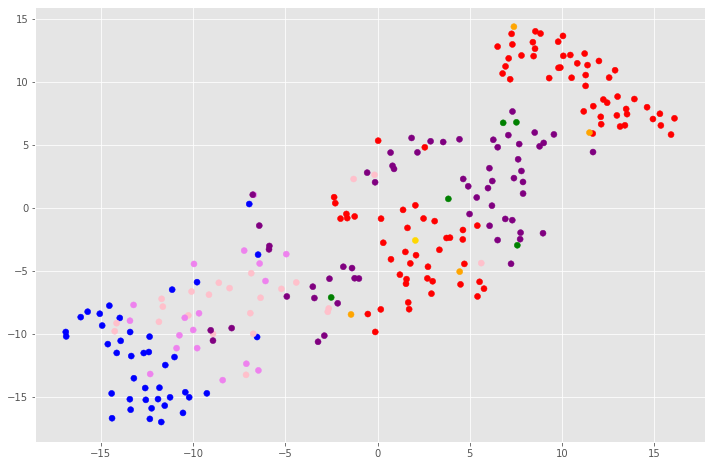

In [4]:
import matplotlib.pyplot as plt

with plt.style.context('ggplot'):
    
    fig, ax = plt.subplots(figsize=(12,8))
    colors = df['position'].map({'DF': 'red', 
                             'MFDF': 'green', 
                             'MF': 'purple', 
                             'MFFW': 'pink', 
                             'FW': 'blue', 
                             'FWMF': 'violet',
                             'DFMF': 'orange', 
                             'DFFW': 'gold'})

    ax.scatter(x=Xs_embedded[:, 0], y=Xs_embedded[:, 1], c=colors)
fig.savefig("scatter_positions.png", dpi=200)    

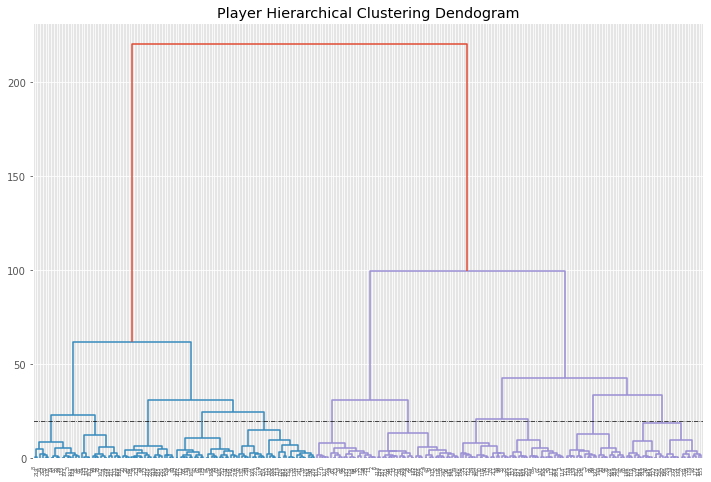

In [5]:
import scipy.cluster.hierarchy as shc

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.title.set(text="Player Hierarchical Clustering Dendogram")
    dend = shc.dendrogram(shc.linkage(Xs_embedded, method='ward'))
    ax.hlines(y=20, xmin=0, xmax=2.5e+3, linestyle='-.', lw=0.7, color='k')
#fig.savefig('dendogram.png', dpi=200)    

In [6]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=N_CLUSTERS)
labels = model.fit_predict(Xs_embedded)
df['label'] = labels

In [7]:
np.bincount(labels)

array([28, 28, 22, 30, 15, 20, 22, 19, 23, 17, 18], dtype=int64)

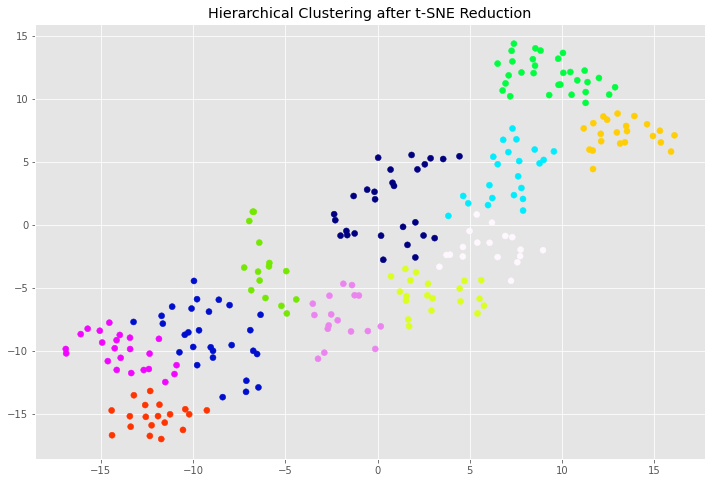

In [8]:
with plt.style.context('ggplot'):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(x=Xs_embedded[:, 0], y=Xs_embedded[:, 1], c=labels, cmap='gist_ncar')
    ax.set_title('Hierarchical Clustering after t-SNE Reduction')
#fig.savefig('clustering_tsne_labelled.png', dpi=200)    

### Interpreting the Clusters

### First Approach - Factor Analysis

In [9]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation='promax', n_factors = N_INTERPRETABLE_DIMS)

fa.fit(X)

FactorAnalyzer(n_factors=8, rotation_kwargs={})

In [10]:
int_Xs = fa.fit_transform(X)

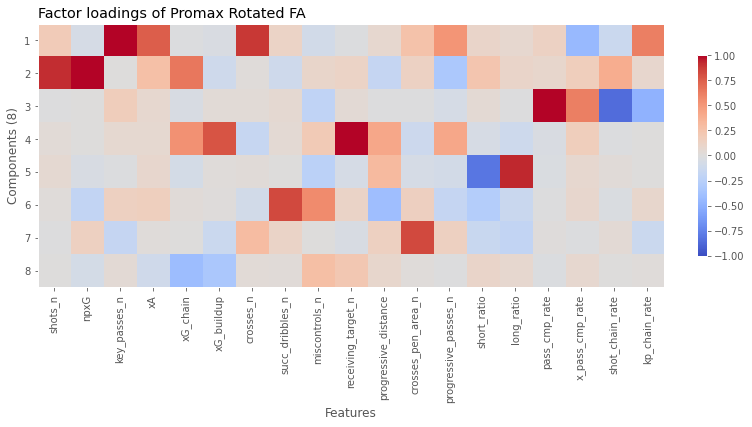

In [11]:
import matplotlib.pyplot as plt

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(fa.loadings_.T, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(N_FEATURES))
    ax.set_yticks(range(N_INTERPRETABLE_DIMS))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticklabels(range(1, N_INTERPRETABLE_DIMS + 1))
    plt.colorbar(im, fraction=0.015)
    ax.set(ylabel = f"Components ({N_INTERPRETABLE_DIMS})", xlabel="Features")
    ax.grid(False)
    ax.title.set(text="Factor loadings of Promax Rotated FA", x=0, ha='left')
#fig.savefig('fa_promax_loadings.png', dpi=200)    

### Varimax PCA

In [12]:
from advanced_pca import CustomPCA
vpca = CustomPCA(n_components=8, rotation='varimax').fit(X)

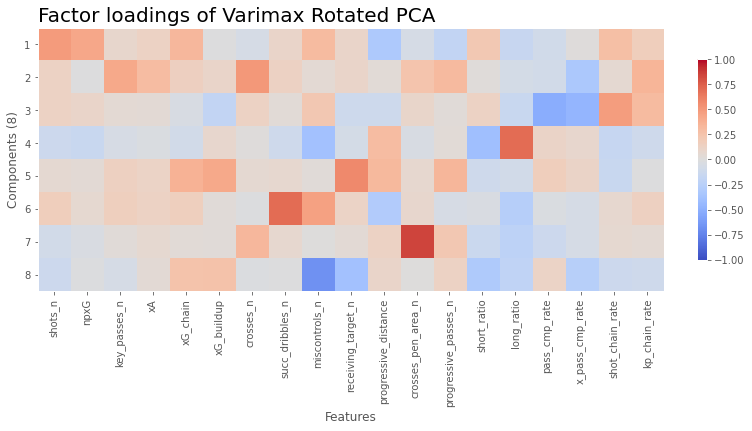

In [13]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(vpca.components_, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(N_FEATURES))
    ax.set_yticks(range(N_INTERPRETABLE_DIMS))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticklabels(range(1, N_INTERPRETABLE_DIMS + 1))
    plt.colorbar(im, fraction=0.015)
    ax.set(ylabel = f"Components ({N_INTERPRETABLE_DIMS})", xlabel="Features")
    ax.grid(False)
    ax.title.set(text="Factor loadings of Varimax Rotated PCA", x=0, ha='left', fontsize=20, y=10)

In [14]:
vcols = ['Creating', 'Shooting', 'Ball retention', 'Build-up', 'Verticality',  'Dribbling', 'Crossing', 'Involvement']

In [15]:
results = pd.DataFrame(scaler.fit_transform(int_Xs), columns = vcols)
results['label'] = df['label']

In [16]:
results.head()

,Creating,Shooting,Ball retention,Build-up,Verticality,Dribbling,Crossing,Involvement,label
0,0.307646,0.148905,0.832773,0.985130,0.587299,0.401901,0.214765,0.515035,6
1,0.331976,0.315174,0.457611,0.460563,0.222881,0.647871,0.460997,0.486418,5
2,0.124582,0.205188,0.827000,0.822460,0.512720,0.280957,0.327781,0.242793,6
3,0.418247,0.468135,0.530385,0.563992,0.482179,0.604587,0.549422,0.250586,9
4,0.387867,0.164365,0.633139,0.761606,0.369742,0.432564,0.577145,0.242504,3


In [17]:
def custom_radar(label, color, ax=None, average=True):
    with plt.style.context('ggplot'):
        ##cleaning and creating radar layout
        if ax is None:
            fig, ax = plt.subplots(subplot_kw={'projection':'polar'}, figsize=(8,8))    
        else:
            fig, ax = ax.get_figure(), ax
        
        thetas = list(np.linspace(0, 2*np.pi, 8, endpoint=False))
        for i in thetas:
            for j in np.linspace(0,1,6, endpoint=True):
                ax.plot([i, i+np.pi/4], [j, j], linestyle='-', color='silver', alpha=.9, lw=1.1, zorder=2)
        ax.grid(b=False, axis='y')
        ax.grid(axis='x', color='silver')
        ax.set_fc('white')
        ax.set(ylim=(0, 1), yticklabels='')

        ax.set_xticks(thetas)
        ax.set_xticklabels(vcols)
        ax.spines['polar'].set_visible(False)
        ax.title.set(text='Cluster Radars')

        ##plotting
        pdf = results.query("label==@label")
        heights = pdf[vcols].mean()
        ax.fill(thetas, heights, color=color, alpha=.2, zorder=10)
        ax.plot(thetas+[thetas[0]], list(heights)+[heights[0]], color=color, label= roles_dict[label], zorder=10, linewidth=3) ##f"Cluster {label} average"
        
        if average:
            league_average_heights = results[vcols].mean()
            ax.fill(thetas, league_average_heights, color='k', ec='k', alpha=.15, zorder=5)
            ax.plot(thetas+[thetas[0]], list(league_average_heights)+[league_average_heights[0]], color='k', label="League average", 
                    zorder=5, linewidth=2, linestyle='-.')

        ax.legend(bbox_to_anchor=(0.85, 0.99))
    return ax


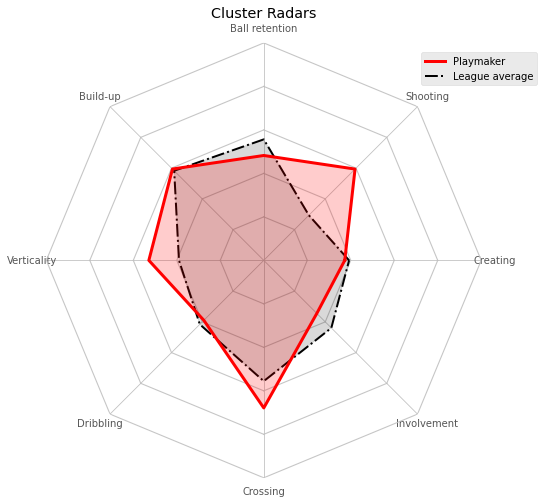

In [20]:
ax = custom_radar(label=4, color='red')
#ax.get_figure().savefig('fa_promax_playmakers_radar.png', dpi=200)

### Promax PCA in psych

In [21]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

nr,nc = X.shape
Xr = ro.r.matrix(X, nrow=nr, ncol=nc)

ro.r.assign("Xr", Xr)
#ro.r("save(Xr, file='here.Rdata')")

0.160703,0.060435,0.172500,...,0.756965,0.215962,0.458873


In [22]:
from rpy2.robjects.packages import importr

psych = importr('psych')
dplyr = importr('dplyr')

In [23]:
fit = psych.principal(Xr, nfactors=8, rotate='promax')

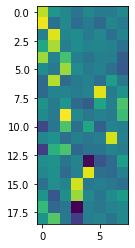

In [24]:
objects_dict = dict(zip(fit.names, list(fit)))
loadings = np.array(objects_dict['loadings'])
plt.imshow(loadings)

In [25]:
array = np.array(objects_dict['scores'])

itp_dims = ['Shooting', 'Creating', 'Build-up', 'Ball retention', 'Verticality', 'Dribbling', 'Crossing', 'Involvement'] ##subjective interpretable metrics

results = pd.DataFrame()
results[['player_name', 'label']] = df[['player_name', 'label']]

results[itp_dims] = array
results[itp_dims] = pd.DataFrame(scaler.fit_transform(results[itp_dims].values), columns=itp_dims, index=results.index) ##scale values to 0,1

In [26]:
results.head()

,player_name,label,Shooting,Creating,Build-up,Ball retention,Verticality,Dribbling,Crossing,Involvement
0,Virgil van Dijk,6,0.164354,0.052800,0.617414,0.865034,0.992581,0.000000,0.221731,0.465618
1,George Baldock,5,0.149394,0.224806,0.229825,0.434429,0.330110,0.267381,0.631920,0.384424
2,Harry Maguire,6,0.209166,0.065986,0.400448,0.857390,0.863615,0.087393,0.184418,0.467900
3,James Ward-Prowse,9,0.234736,0.443856,0.302112,0.308156,0.538874,0.122686,0.253279,0.353044
4,James Tarkowski,3,0.219403,0.113044,0.049309,0.466045,0.879612,0.123818,0.141322,0.499904


#### Plotting Radars

In [27]:
def custom_radar(label, color, ax=None, average=True):
    with plt.style.context('ggplot'):
        ##cleaning and creating radar layout
        if ax is None:
            fig, ax = plt.subplots(subplot_kw={'projection':'polar'}, figsize=(8,8))    
        else:
            fig, ax = ax.get_figure(), ax
        
        thetas = list(np.linspace(0, 2*np.pi, 8, endpoint=False))
        for i in thetas:
            for j in np.linspace(0,1,6, endpoint=True):
                ax.plot([i, i+np.pi/4], [j, j], linestyle='-', color='silver', alpha=.9, lw=1.1, zorder=2)
        ax.grid(b=False, axis='y')
        ax.grid(axis='x', color='silver')
        ax.set_fc('white')
        ax.set(ylim=(0, 1), yticklabels='')

        ax.set_xticks(thetas)
        ax.set_xticklabels(itp_dims)
        ax.spines['polar'].set_visible(False)
        ax.title.set(text='Cluster Radars')

        ##plotting
        pdf = results.query("label==@label")
        heights = pdf[itp_dims].mean()
        ax.fill(thetas, heights, color=color, alpha=.2, zorder=10)
        ax.plot(thetas+[thetas[0]], list(heights)+[heights[0]], color=color, label=roles_dict[label], zorder=10, linewidth=3)
        
        if average:
            league_average_heights = results[itp_dims].mean()
            ax.fill(thetas, league_average_heights, color='k', ec='k', alpha=.15, zorder=5)
            ax.plot(thetas+[thetas[0]], list(league_average_heights)+[league_average_heights[0]], color='k', label="League average", 
                    zorder=5, linewidth=2, linestyle='-.')

        ax.legend(bbox_to_anchor=(0.82, 0.95))
    return fig, ax



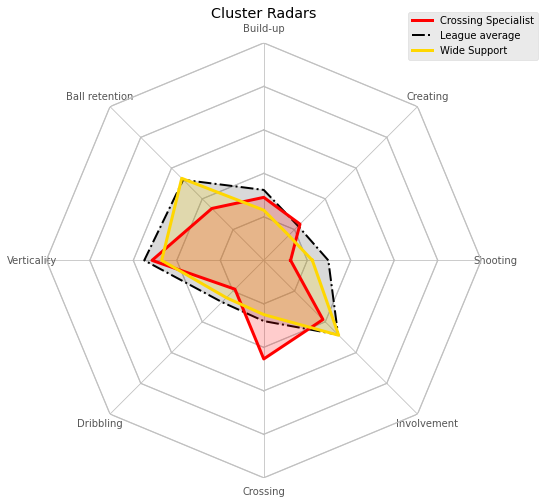

In [28]:
label1, label2 = 5, 10
fig, ax = custom_radar(label1, 'red')
fig, ax = custom_radar(label2, 'gold', ax, average=False)
#fig.savefig('crossing_wide_supp_comparison.png', dpi=200)


In [19]:
roles_dict = { 0: 'Recycler',
               1: 'Wide Attacker',
               2: 'Pivot',
               3: 'Backfield Outlet',
               4: 'Playmaker',
               5: 'Crossing Specialist',
               6: 'Ball-Playing Def.',
               7: 'Pure Scorer',
               8: 'Hybrid Scorer',
               9: 'Support Attacker',
               10:'Wide Support'
              }